---
title: Step 03 - Featurization, Vectorization, and Pre-Modeling
subject: Churn Analysis
subtitle: Step 03 - Featurization, Vectorization, and Pre-Modeling - Churn Analysis
short_title: Featurization, Vectorization, and Pre-Modeling
date: 2025-12-17


affiliations:
  - id: "ucb"
    name: "University of California, Berkeley"

authors:
  - name: Jocelyn Perez
    affiliations: ["ucb"]
    email: jocelyneperez@berkeley.edu
    orcid: 0009-0009-0231-9254

  - name: Claire Kaoru Shimazaki
    affiliations: ["ucb"]
    email: ckshimazaki@berkeley.edu
    orcid: 0009-0001-0828-3370

  - name: Colby Zhang
    affiliations: ["ucb"]
    email: colbyzhang@berkeley.edu
    orcid: 0009-0005-4786-6922

  - name: Olorundamilola Kazeem
    affiliations: ["ucb"]
    email: dami@berkeley.edu
    orcid: 0000-0003-2118-2221

# https://mystmd.org/guide/frontmatter#frontmatter-downloads
# https://mystmd.org/guide/website-downloads
# downloads:
#   -  ...

# https://mystmd.org/guide/website-downloads#include-exported-pdf
# exports:
#   - format: pdf
#     template: lapreprint-typst
#     output: exports/my-document.pdf
#     id: my-document-export
# downloads:
#   - id: my-document-export
#     title: A PDF of this document

exports:
  - format: pdf
    template: lapreprint-typst
    output: ../pdf_builds/step03_features/step03_features_ipynb_to.pdf
    line_numbers: true

license: CC-BY-4.0

keywords: featurization, vectorization, pre-modeling, churn, spotify

abstract: What are the pre-processing of the features? How is the data being vectorized? 
---

### The Engagement Hypothesis
Raw data tell us *what* a user did, but not *how they felt*. To build a robust churn model, we must transform raw metrics into interpretable **Behavioral Signals**.

In this notebook, we focus on three tasks:
1.  **Feature Engineering:** Creating interaction terms (like `ads_per_song`) that measure "user friction" better than raw counts.
2.  **Stratified Splitting:** Ensuring our training data preserves the Churn/Non-Churn ratio of the real world.
3.  **Pipeline Construction:** Building a leak-proof transformation pipeline that handles missing data and scales numerical values for machine learning algorithms.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import set_config

import src.step03_features as step03
import src.step00_utils as utils

RAW_DATA_PATH = step03.RAW_DATA_PATH
PROCESSED_DATA_DIR = step03.PROCESSED_DATA_DIR
VECTORIZED_DATA_DIR = step03.VECTORIZED_DATA_DIR
# FIG_DIR = step03.DIR_DATA.parent / "fig_builds" / "step03_features"
FIG_DIR = utils.DIR_OUTPUTS_FIG_BUILDS_03_FEATURES

# Feature Engineering

We import our custom logic from `src.step03_features`. We hypothesize that churn is driven by "efficiency of use" and "ad tolerance."

- `avg_song_length`: A proxy for engagement intensity. User who listen to longer songs (or don't skip halfway through) likely have a higher "stickiness."
- `ads_per_song`: A "frustration metric." A high ratio here suggests that user is being bombarded with ads relative to the content they consume, increasing churn risk.

New columns created: ['ads_per_song', 'avg_song_length']


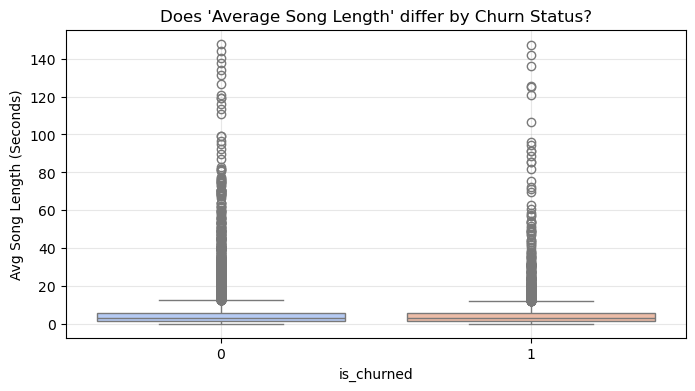

In [2]:
df = pd.read_csv(RAW_DATA_PATH)

# engineer features
df_engineered = step03.engineer_features(df)

print("New columns created:", [c for c in df_engineered.columns if c in ['ads_per_song', 'avg_song_length']])

plt.figure(figsize=(8, 4))
sns.boxplot(x='is_churned', y='avg_song_length', hue='is_churned', legend=False, data=df_engineered, palette='coolwarm')
plt.title("Does 'Average Song Length' differ by Churn Status?")
plt.ylabel("Avg Song Length (Seconds)")
plt.grid(True, alpha=0.3)

plt.savefig(FIG_DIR / "step03_feature_boxplot.png", bbox_inches='tight', dpi=300)
plt.show()

# Data Splitting

Churn datasets are often "imbalanced" (fewer people churn than stay). If we split the data randomly, our test set might end up with zero churners, making evaluation meaningless.

We use **Stratified Sampling** (`stratify=y`) to lock the class distribution. This guarantees that if 20% of users churn in reality, exactly 20% of users churn in our training set and our test set.

In [3]:
# X = features, y = target
X, y = step03.make_X_y(df_engineered)

# train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Data Shape: {X_train.shape}")
print(f"Test Data Shape:     {X_test.shape}")
print(f"Training Churn Rate: {y_train.mean():.1%}")
print(f"Testing Churn Rate:  {y_test.mean():.1%}")

Training Data Shape: (6400, 12)
Test Data Shape:     (1600, 12)
Training Churn Rate: 25.9%
Testing Churn Rate:  25.9%


# The Preprocessing Pipeline

To prepare our data for modeling, we contrusct a **Scikit-Learn Pipeline**. This encapsulates all transformations into a single object, preventing "data leakage" (where test data accidentally influences training calculations).
- **Numeric Features** -> Imputed (Median) -> Scaled (StandardScalar)
- **Categorical Features** -> One-Hot Encoded


In [4]:
set_config(display='diagram')

# build and fit preprocessor
preprocessor = step03.build_preprocessor()
preprocessor.fit(X_train)

# transform both sets
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Original Shape:  {X_train.shape}")
print(f"Processed Shape: {X_train_processed.shape}")

preprocessor

Original Shape:  (6400, 12)
Processed Shape: (6400, 26)


,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. e

In [5]:
# save preprocessor and processed data for step04_modeling
joblib.dump(preprocessor, VECTORIZED_DATA_DIR / "preprocessor.joblib")
joblib.dump({"X": X_train_processed, "y": y_train}, VECTORIZED_DATA_DIR / "train.joblib")
joblib.dump({"X": X_test_processed, "y": y_test}, VECTORIZED_DATA_DIR / "test.joblib")

print("All files saved to:", VECTORIZED_DATA_DIR)

All files saved to: /home/jovyan/Projects/STAT_159_259/final-group08/data/02_vectorized


### Summary:
"In this notebook, we established a robust feature engineering pipeline to prepare the data for modeling, directly applying insights from the EDA. We addressed data quality by imputing missing values and scaling distributions, then engineered interaction features such as `ads_per_song` and `avg_song_length` to better capture user dissatisfaction and engagement depth. Finally, we implemented a stratified 80/20 train-test split and applied a preprocessing pipeline—using `StandardScaler` for numeric features and `OneHotEncoder` for categoricals—saving the vectorized datasets to ensure consistent inputs for the subsequent modeling phase."